## **Parte 2: Red Neuronal**

Ya habiendo hecho todas las transformaciones a nuestro dataframe, podemos empezar a plantear nuestra red. 

### **Punto 1:** Arquitectura  

Primero, arrancamos mostrando un diagrama sencillo de la red neuronal. Luego vendrán las explicaciones pertinentes. 

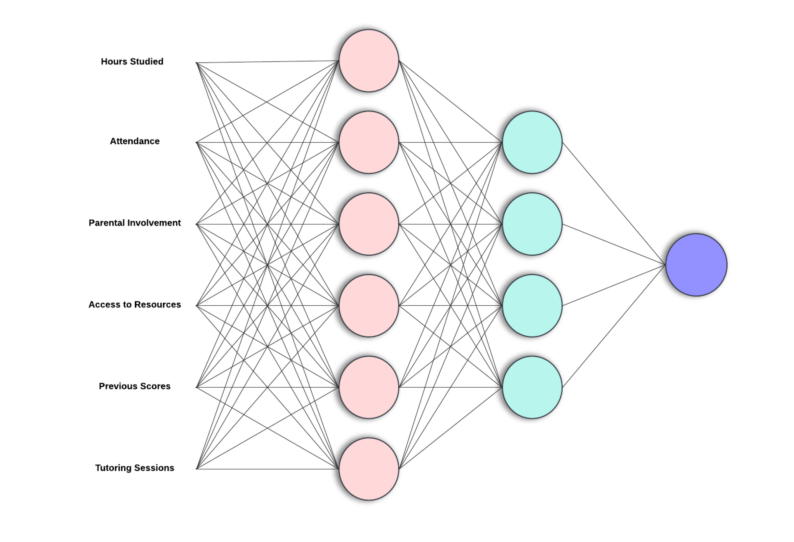

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


image_path = 'Diagrama_de_Red_Neuronal.png'  


img = mpimg.imread(image_path)

plt.figure(figsize=(10, 8))


plt.imshow(img)
plt.axis('off')  
plt.show()

**Capa de Entrada**: Está formada por 6 neuronas, cada una para cada columna de caracterísitcas. En el gráfico estos nodos están representados por los nombres de las columnas.  

**Capas Ocultas**: Hay dos de ellas   
* **La primera** compuesta por seis neuronas, y en ella se aplicará la función de activación Leaky ReLU. Opté por no usar ReLU directamente ya que en mi dataframe tengo muchos valores negativos, y con ReLU podría tener problema con las neuronas muertas. De ser necesario, según los resultados del accuracy de mi red, podré probar Parametric ReLU en lugar de esta función.  
* **La segunda** está compuesta por 4 neuronas. Claro que, como la capa anterior, esta decisión es aleatoria. La función activación en esta capa es Logísitca, que me acota los resultados entre 0 y 1. Viene perfecto ya que tendré una salida binaria.  

**Capa de Salida**: Será de una sola neurona, ya que tendré un 0 o un 1. 

### **Punto2**: Implementación de la Red con Numpy

##### **Forward Propagation**


In [2]:
import numpy as np
import pandas as pd

df = pd.read_csv("Factores_de_Buen_Rendimiento_en_Estudiantes_actualizado.csv")

inputs = df.iloc[:,:-1].values #Tomo mis entradas de todas las columnas excepto la ultima
outputs = df.iloc[:,-1].values #Tomo la salida de la última columna


#Inicio los pesos y sesgos aleatoriamente con una semilla establecida, y siempre obtendremos los mismos valores
np.random.seed(42)
w_hidden1 = np.random.rand(6, 6)
w_hidden2 = np.random.rand(4, 6) #Esto al principio me equivoque y use (6, 4) ;_; estuve 15 mins haciendo todos los dibujos de matrices de nuevo pq me confundi al escribir
w_output = np.random.rand(1, 4)

b_hidden1 = np.random.rand(6, 1)
b_hidden2 = np.random.rand(4, 1)
b_output = np.random.rand(1, 1)

leaky_relu = lambda x: np.maximum(0.01*x, x)#Mis funciones de activacion
logistic = lambda x: 1 / (1 + np.exp(-x))

def forward_prop(X):

    Z1 = w_hidden1 @ X + b_hidden1

    A1 = leaky_relu(Z1)

    Z2 = w_hidden2 @ A1 + b_hidden2

    A2 = leaky_relu(Z2)

    Z3 = w_output @ A2 + b_output

    A3 = logistic(Z3)

    return Z1, A1, Z2, A2, Z3, A3

##### **Back propagation**

In [3]:
d_leaky_relu = lambda x: np.where(x < 0, 0.1, 1)
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

def backward_prop(Z1,A1,Z2,A2,Z3,A3,X,Y):

    dC_dA3 = 2*A3 - 2*Y #Derivada de la funcion de costo (A3 - Y)**2 respecto de A3
    dA3_dZ3 = d_logistic(Z3)
    dZ3_dA2 = w_output
    dZ3_dW3 = A2 
    dZ3_dB3 = 1
    dA2_dZ2 = d_leaky_relu(Z2)
    dZ2_dA1 = w_hidden2
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dA1_dZ1 = d_leaky_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    dC_dZ3 = dC_dA3 * dA3_dZ3
    dC_dA2 = dZ3_dA2.T @ dC_dZ3

    dC_dZ2 = dC_dA2 * dA2_dZ2
    dC_dA1 = dZ2_dA1.T @ dC_dZ2

    dC_dZ1 = dC_dA1 * dA1_dZ1

    
    dC_dW3 = dC_dZ3 @ dZ3_dW3.T
    dC_dW2 = dC_dZ2 @ dZ2_dW2.T
    dC_dW1 = dC_dZ1 @ dZ1_dW1.T

    dC_dB3 = dC_dZ3 * dZ3_dB3
    dC_dB2 = dC_dZ2 * dZ2_dB2
    dC_dB1 = dC_dZ1 * dZ1_dB1 

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3


##### **Ajuste de los pesos**

In [4]:
from sklearn.model_selection import train_test_split

L = 0.05#Empiezo con esta tasa de aprendizaje 

X_train, X_test, Y_train, Y_test = train_test_split(inputs, outputs, test_size=1 / 3)
n = X_train.shape[0]

#Lista para usar en el siguiente punto 

for i in range(100_000):#Empiezo con esta cantidad de iteraciones
    # aleatoriamente selecciona uno de los datos de entrnamiento
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    
    dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

        
    w_hidden1 -= L * dW1
    b_hidden1 -= L * dB1
    w_hidden2 -= L * dW2
    b_hidden2 -= L * dB2
    w_output -= L * dW3
    b_output -= L * dB3

    #22.7 ejecucion

### **Punto 3:** Entrenaminto y evaluacion

Habiendo hecho ya las preparaciones en el punto anterior, voy a empezar a entrenar la red buscando el numero de iteraciones y tasa de aprendizaje con el que consiga mayor accuracy

In [5]:
import matplotlib.pyplot as plt 

def graficar_accuracy(L, train_l, test_l):

    iters = len(test_l)

    fmt_train = {
        'color': 'tab:blue',
        'ls': 'solid',
        'lw': 3,
    }

    fmt_test = {
        'color': 'tab:orange',
        'ls': 'solid',
        'lw': 3,
    }

    fig, (ax) = plt.subplots(1,1, figsize=(10,8))

    ax.plot(train_l, label='Train', **fmt_train)
    ax.plot(test_l, label ='Test', **fmt_test)

    ax.grid(which='both')
    ax.legend()
    ax.set_title(f"Accuracy {L=}")
    ax.set_xlabel('Step')

    fig.tight_layout()
    plt.savefig(f"accuracy_{L=}_{iters=}.png")

In [6]:
def mi_red_neuronal(L, iters):
    
    np.random.seed(42)
    w_hidden1 = np.random.rand(6, 6)
    w_hidden2 = np.random.rand(4, 6) #Esto al principio me equivoque y use (6, 4) ;_; estuve 15 mins haciendo todos los dibujos de matrices de nuevo pq me confundi al escribir
    w_output = np.random.rand(1, 4)

    b_hidden1 = np.random.rand(6, 1)
    b_hidden2 = np.random.rand(4, 1)
    b_output = np.random.rand(1, 1)

    leaky_relu = lambda x: np.maximum(0.01*x, x)#Mis funciones de activacion
    logistic = lambda x: 1 / (1 + np.exp(-x))

    def forward_prop(X):

        Z1 = w_hidden1 @ X + b_hidden1

        A1 = leaky_relu(Z1)

        Z2 = w_hidden2 @ A1 + b_hidden2

        A2 = leaky_relu(Z2)

        Z3 = w_output @ A2 + b_output

        A3 = logistic(Z3)

        return Z1, A1, Z2, A2, Z3, A3
    
        
    d_leaky_relu = lambda x: np.where(x < 0, 0.1, 1)
    d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

    def backward_prop(Z1,A1,Z2,A2,Z3,A3,X,Y):

        dC_dA3 = 2*A3 - 2*Y #Derivada de la funcion de costo (A3 - Y)**2 respecto de A3
        dA3_dZ3 = d_logistic(Z3)
        dZ3_dA2 = w_output
        dZ3_dW3 = A2 
        dZ3_dB3 = 1
        dA2_dZ2 = d_leaky_relu(Z2)
        dZ2_dA1 = w_hidden2
        dZ2_dW2 = A1
        dZ2_dB2 = 1
        dA1_dZ1 = d_leaky_relu(Z1)
        dZ1_dW1 = X
        dZ1_dB1 = 1

        dC_dZ3 = dC_dA3 * dA3_dZ3
        dC_dA2 = dZ3_dA2.T @ dC_dZ3

        dC_dZ2 = dC_dA2 * dA2_dZ2
        dC_dA1 = dZ2_dA1.T @ dC_dZ2

        dC_dZ1 = dC_dA1 * dA1_dZ1

    
        dC_dW3 = dC_dZ3 @ dZ3_dW3.T
        dC_dW2 = dC_dZ2 @ dZ2_dW2.T
        dC_dW1 = dC_dZ1 @ dZ1_dW1.T

        dC_dB3 = dC_dZ3 * dZ3_dB3
        dC_dB2 = dC_dZ2 * dZ2_dB2
        dC_dB1 = dC_dZ1 * dZ1_dB1 

        return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3
    
    
    accuracy_test_l = []
    accuracy_train_l = []

    for i in range(iters):#Empiezo con esta cantidad de iteraciones
        # aleatoriamente selecciona uno de los datos de entrnamiento
        idx = np.random.choice(n, 1, replace=False)
        X_sample = X_train[idx].transpose()
        Y_sample = Y_train[idx]

    
        Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    
        dW1, dB1, dW2, dB2, dW3, dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

        
        w_hidden1 -= L * dW1
        b_hidden1 -= L * dB1
        w_hidden2 -= L * dW2
        b_hidden2 -= L * dB2
        w_output -= L * dW3
        b_output -= L * dB3

        #Lo siguiente lo seteo acá para usarlo en el proximo punto

        train_predictions = forward_prop(X_train.transpose())[5] #En el indice 5 de la tupla que devuelve forward_prop está A3
        train_comparisons = np.equal((train_predictions >= .5).flatten().astype(int), Y_train)#Comparamos las predicciones con los valores reales
        accuracy_train = sum(train_comparisons.astype(int)) / X_train.shape[0] #Acá se calcula el porcentaje de las predicciones acertadas
        accuracy_train_l.append(accuracy_train)
        
   
    
        test_predictions = forward_prop(X_test.transpose())[5]#Lo mismo que arriba
        test_comparisons = np.equal((test_predictions >= .5).flatten().astype(int), Y_test)
        accuracy_test = sum(test_comparisons.astype(int)) / X_test.shape[0]
        accuracy_test_l.append(accuracy_test)

    graficar_accuracy(L, accuracy_train_l, accuracy_test_l)
    print(f"{iters}-{L} => TRAIN ACCURACY: {accuracy_train}")
    print(f"{iters}-{L} => TEST ACCURACY: {accuracy_test}")

500-0.01 => TRAIN ACCURACY: 0.781120078258743
500-0.01 => TEST ACCURACY: 0.7569682151589242
500-0.05 => TRAIN ACCURACY: 0.9102470041574957
500-0.05 => TEST ACCURACY: 0.9183374083129584
500-0.005 => TRAIN ACCURACY: 0.2301296160430423
500-0.005 => TEST ACCURACY: 0.2449877750611247
1000-0.01 => TRAIN ACCURACY: 0.8904377598434825
1000-0.01 => TEST ACCURACY: 0.8880195599022005
1000-0.05 => TRAIN ACCURACY: 0.9124480313034972
1000-0.05 => TEST ACCURACY: 0.917359413202934
1000-0.005 => TRAIN ACCURACY: 0.8314991440449988
1000-0.005 => TEST ACCURACY: 0.823960880195599
3000-0.01 => TRAIN ACCURACY: 0.9197847884568354
3000-0.01 => TEST ACCURACY: 0.9198044009779951
3000-0.05 => TRAIN ACCURACY: 0.9131817070188311
3000-0.05 => TEST ACCURACY: 0.9183374083129584
3000-0.005 => TRAIN ACCURACY: 0.9134262655906089
3000-0.005 => TEST ACCURACY: 0.9119804400977995
10000-0.01 => TRAIN ACCURACY: 0.9195402298850575
10000-0.01 => TEST ACCURACY: 0.9163814180929095
10000-0.05 => TRAIN ACCURACY: 0.921496698459281
100

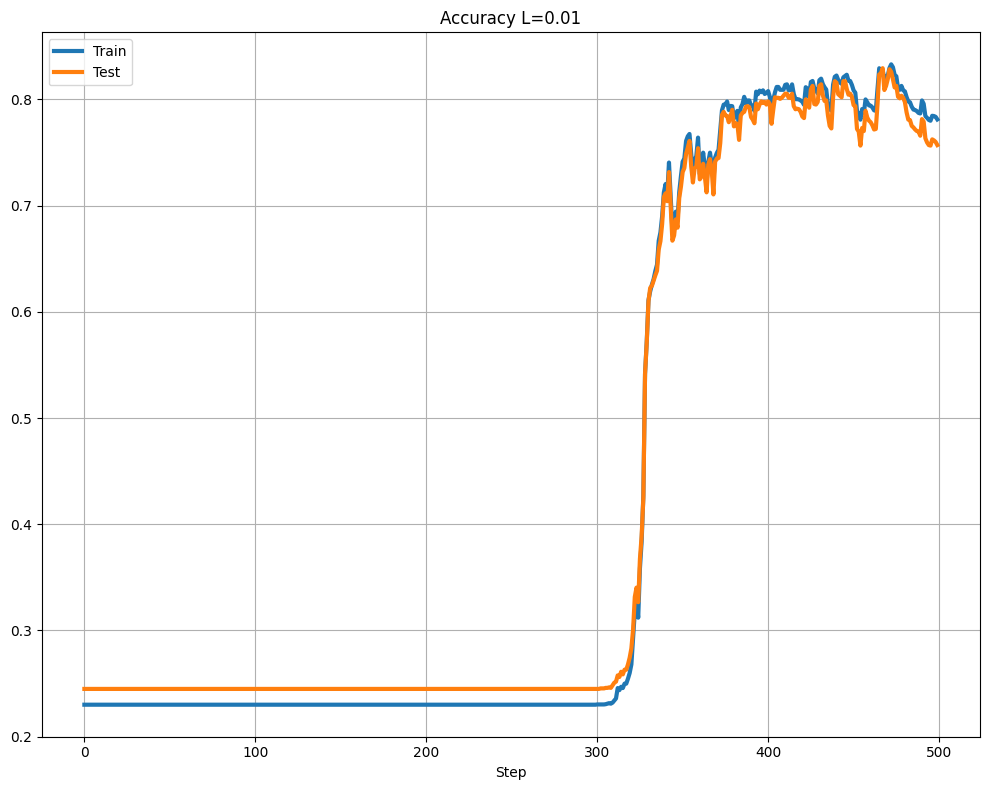

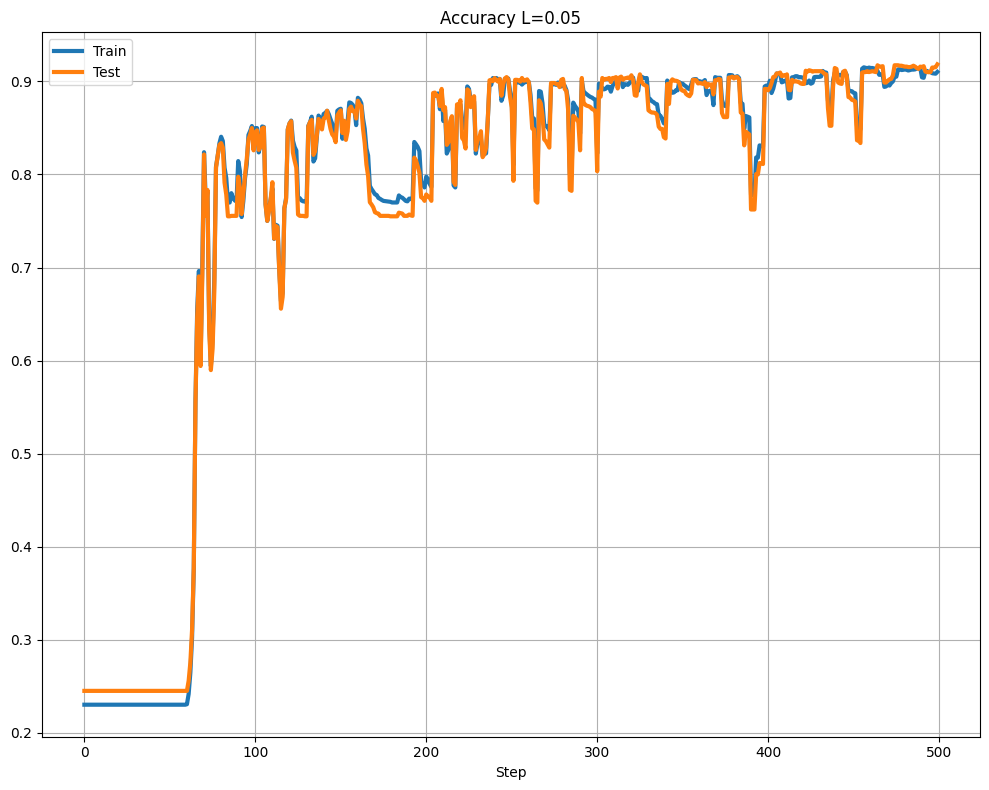

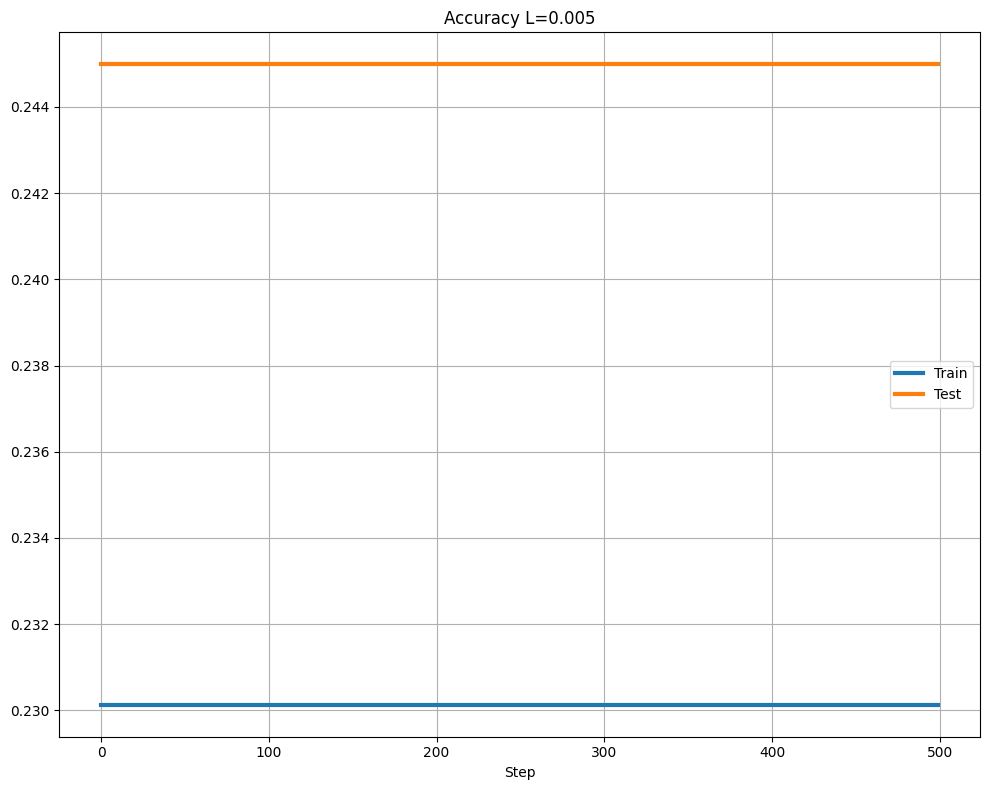

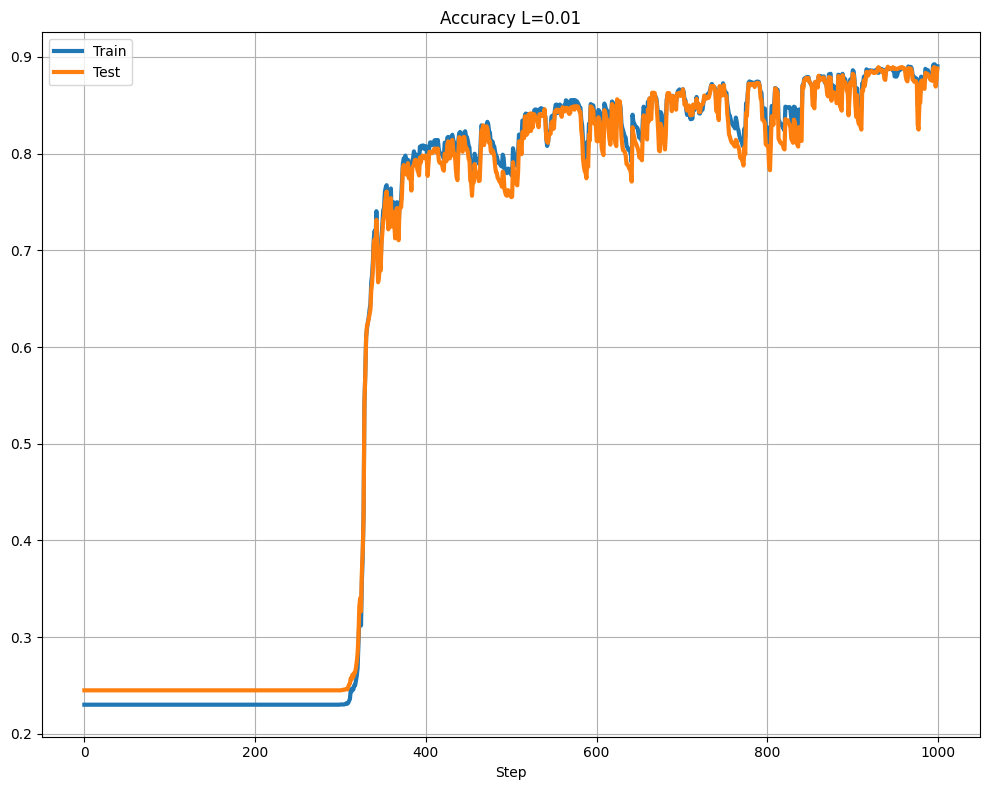

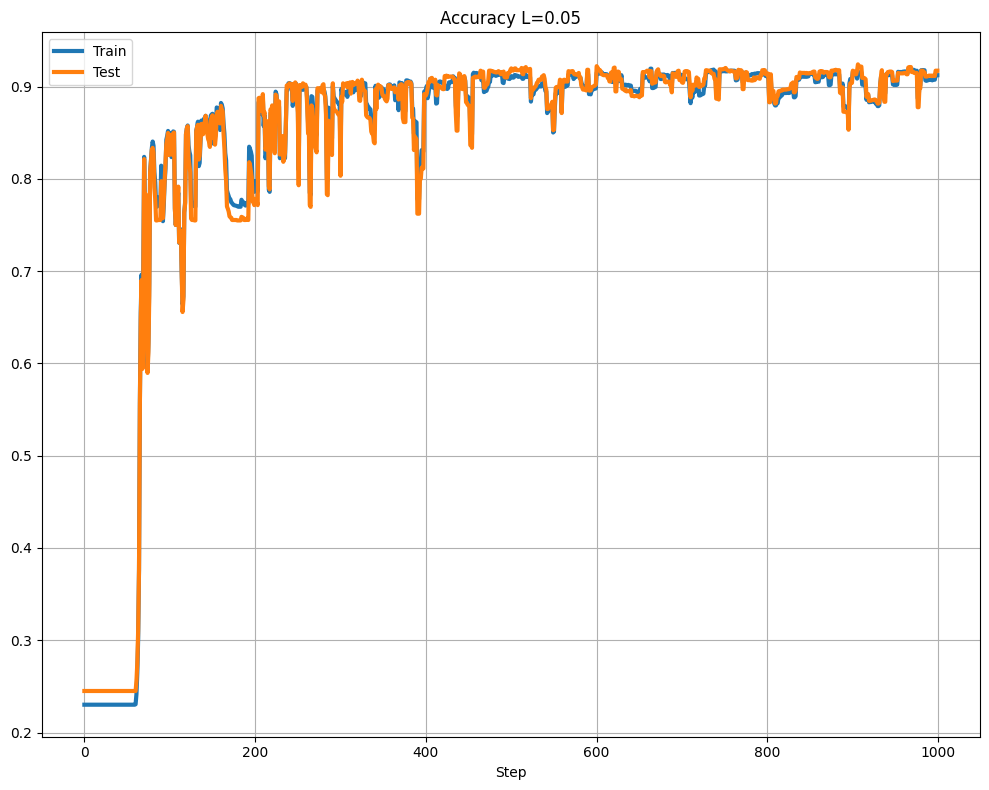

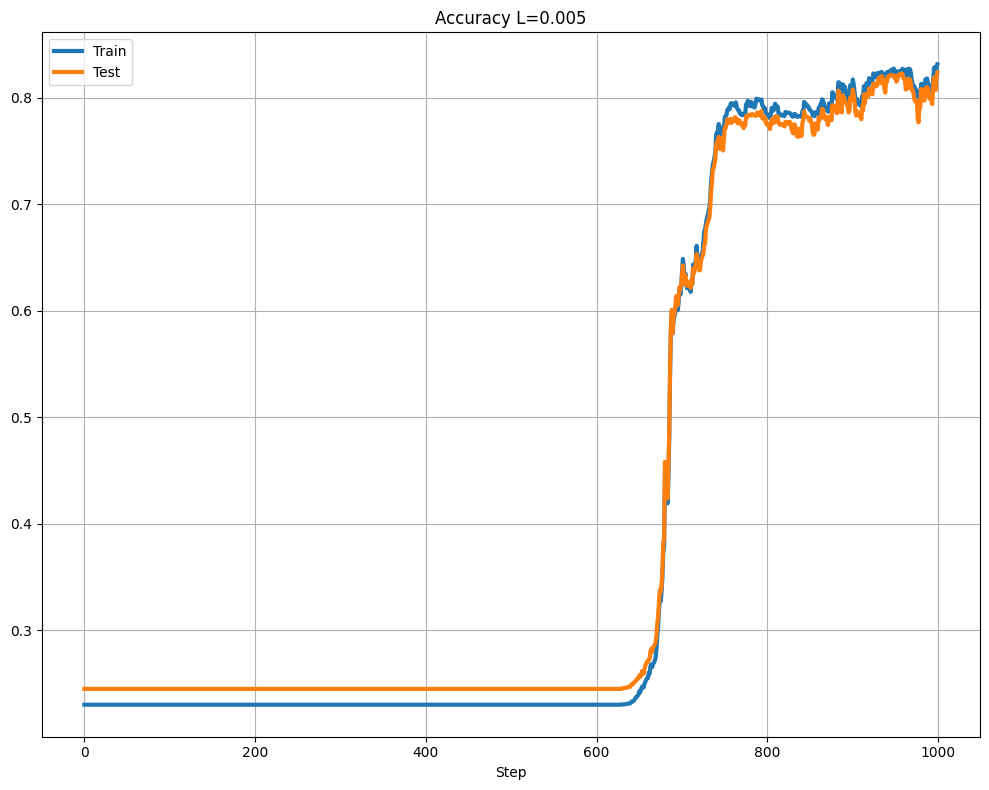

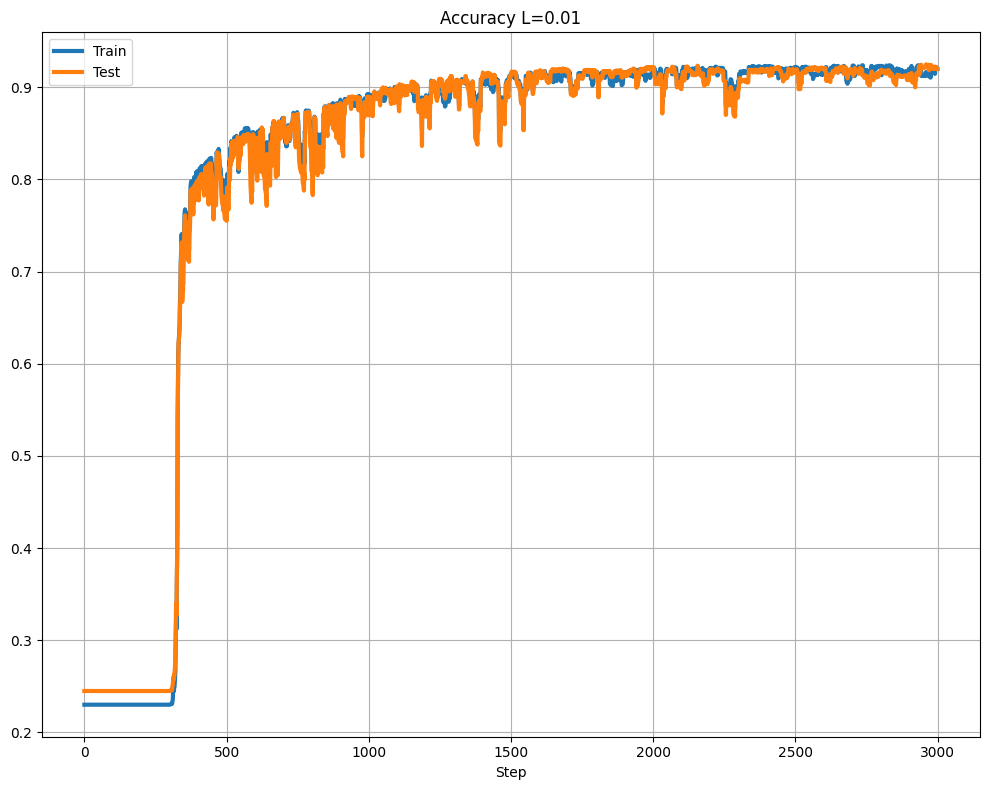

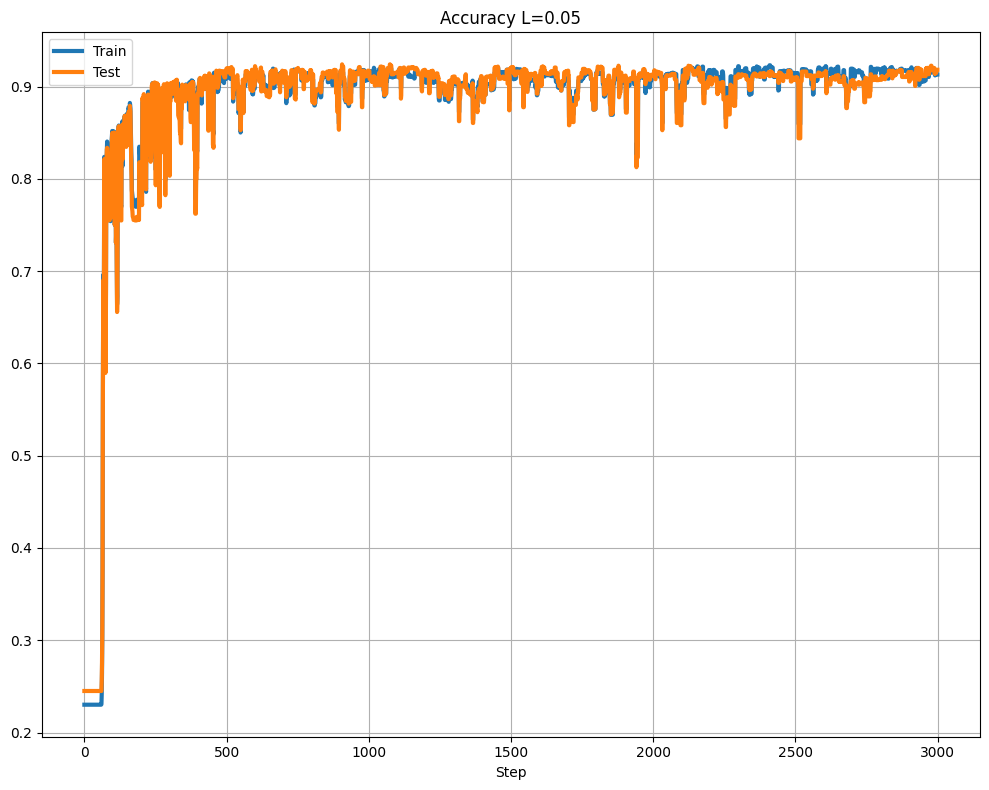

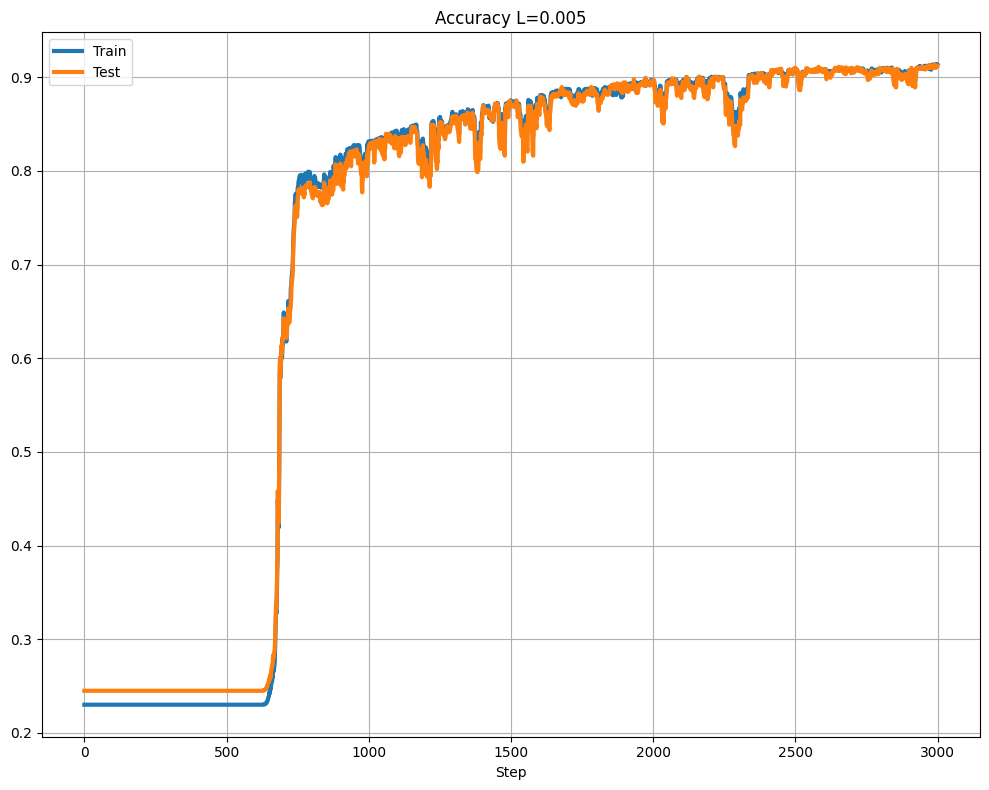

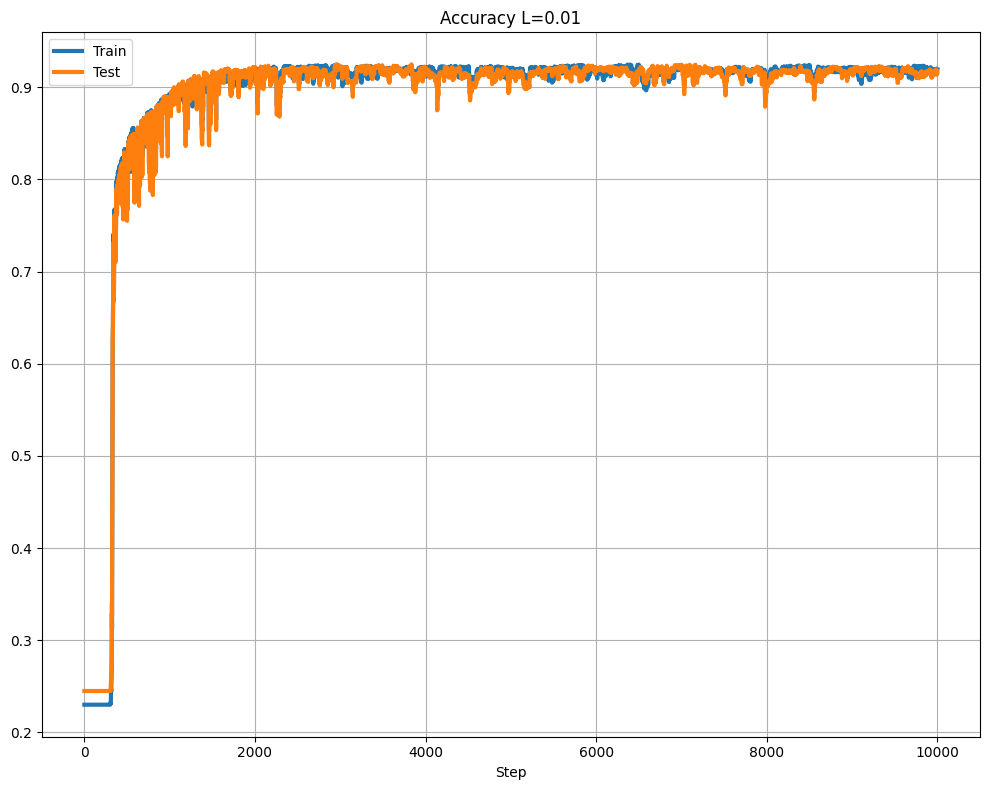

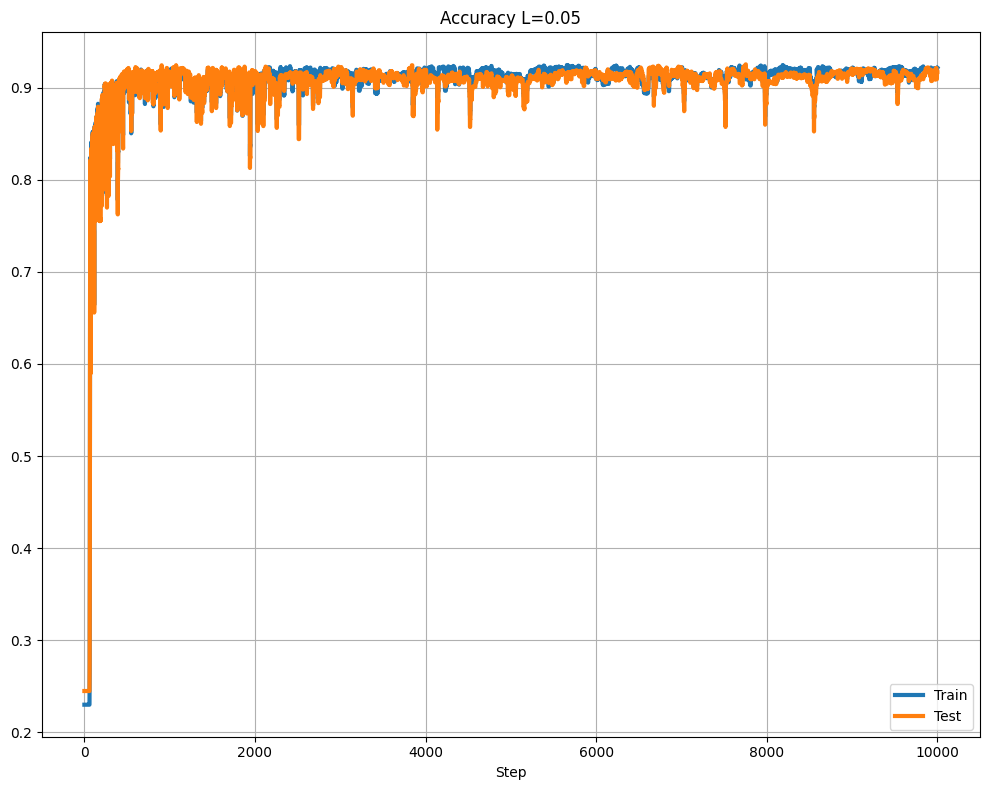

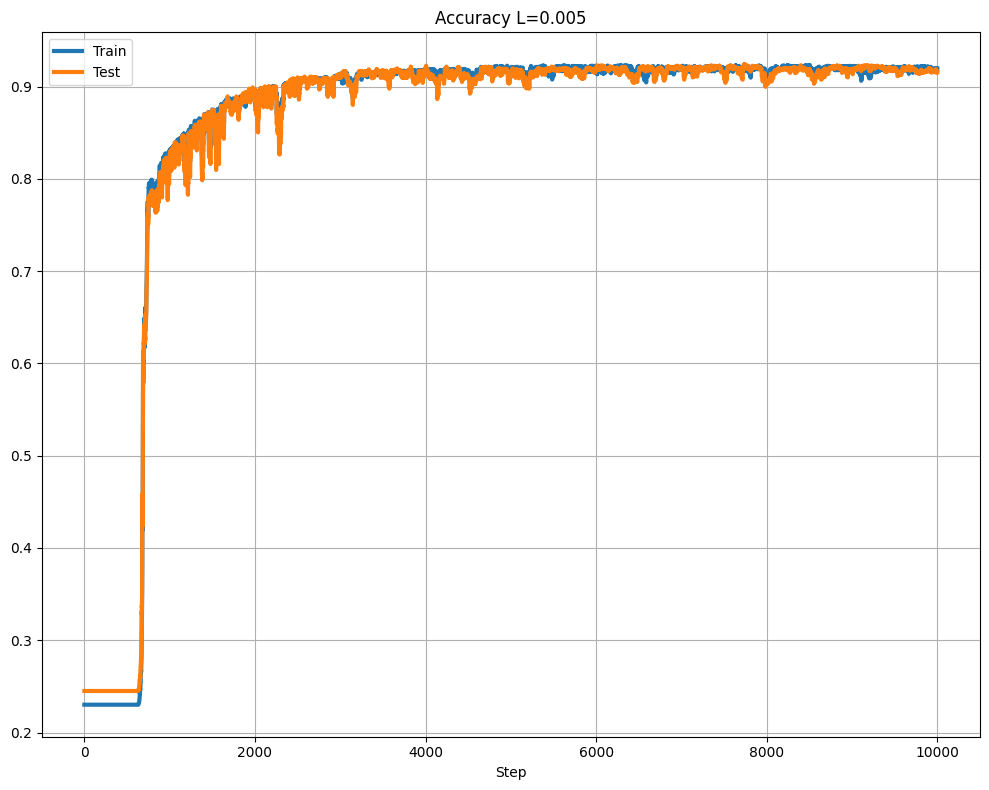

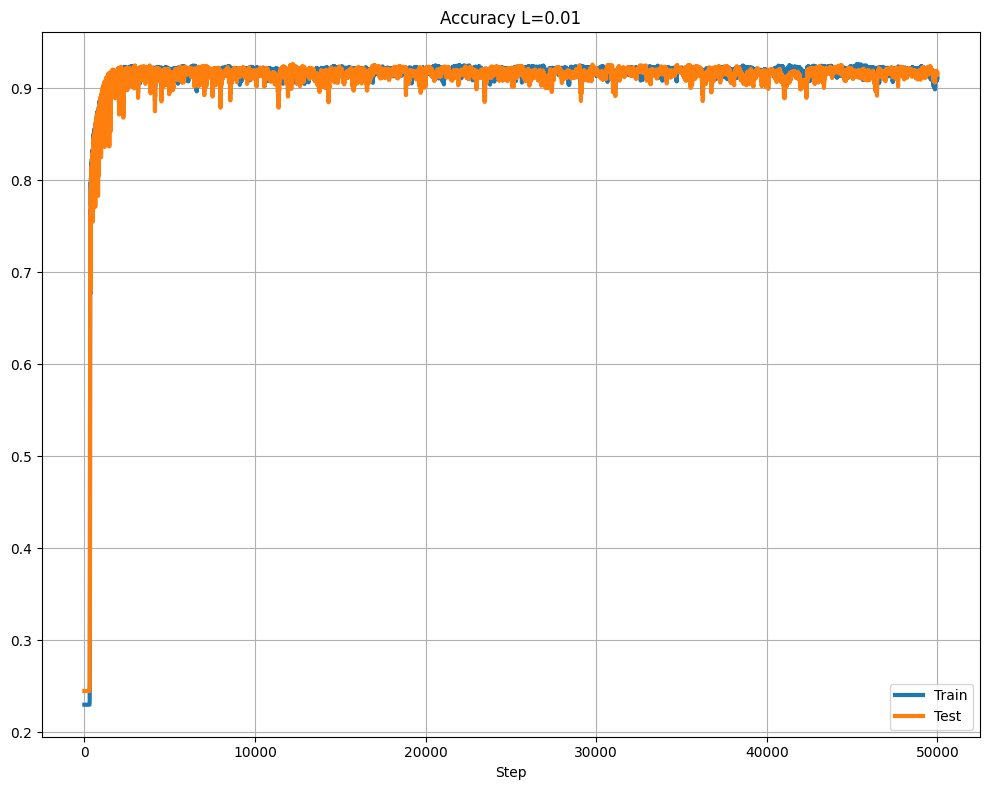

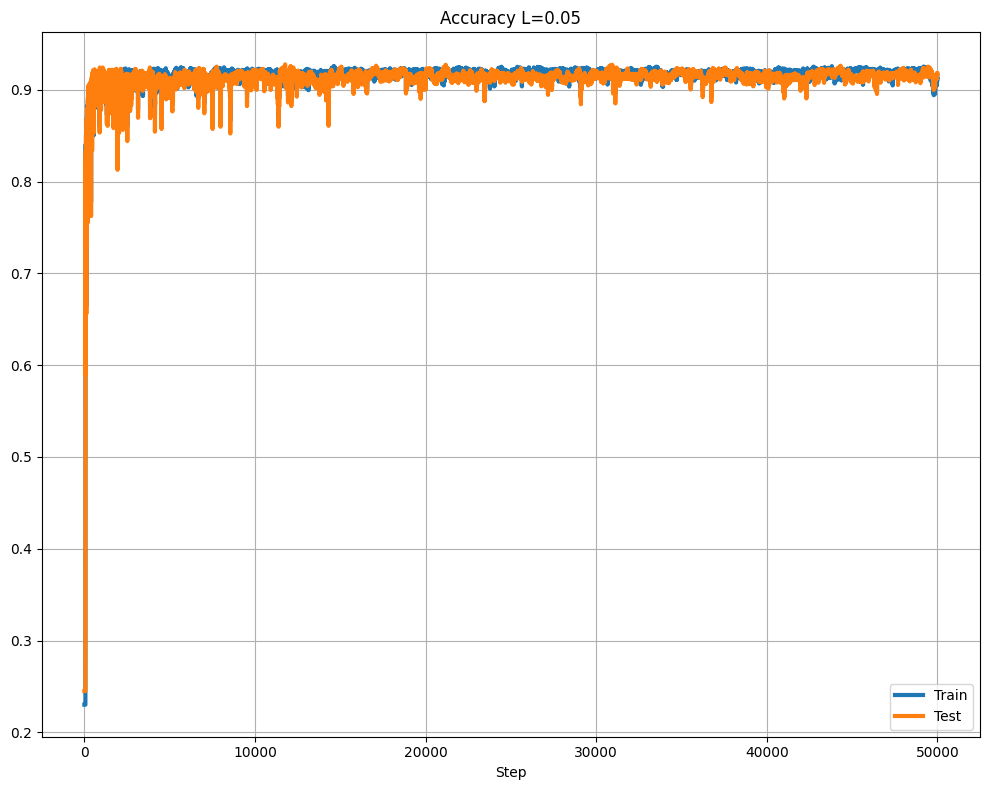

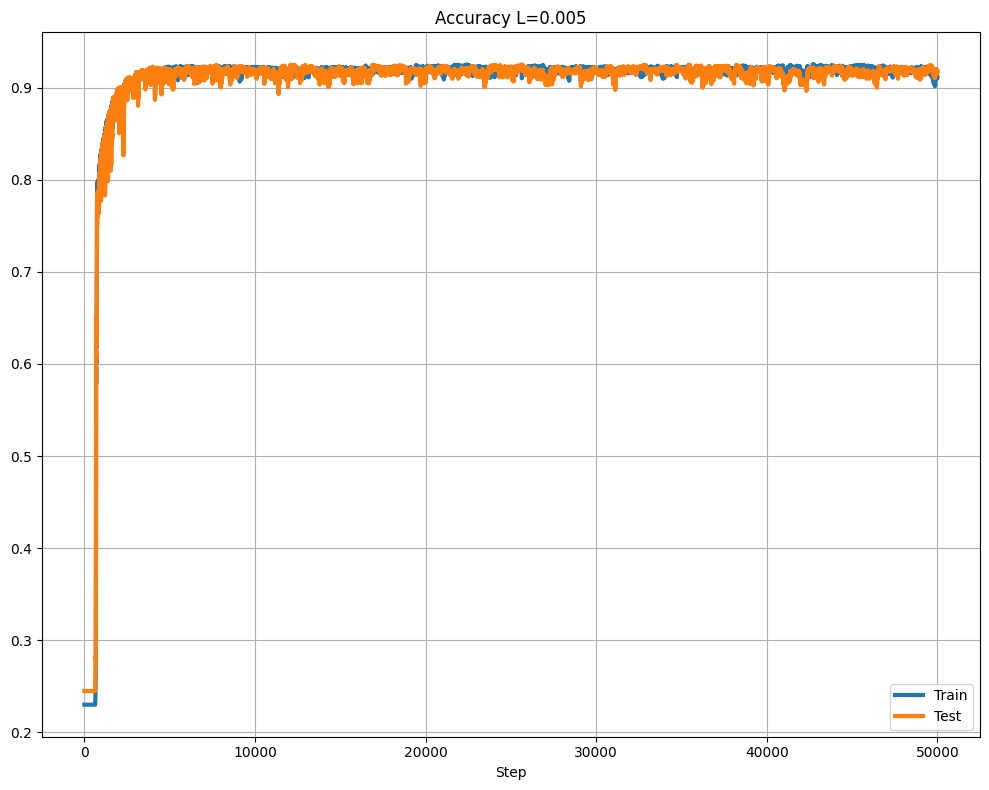

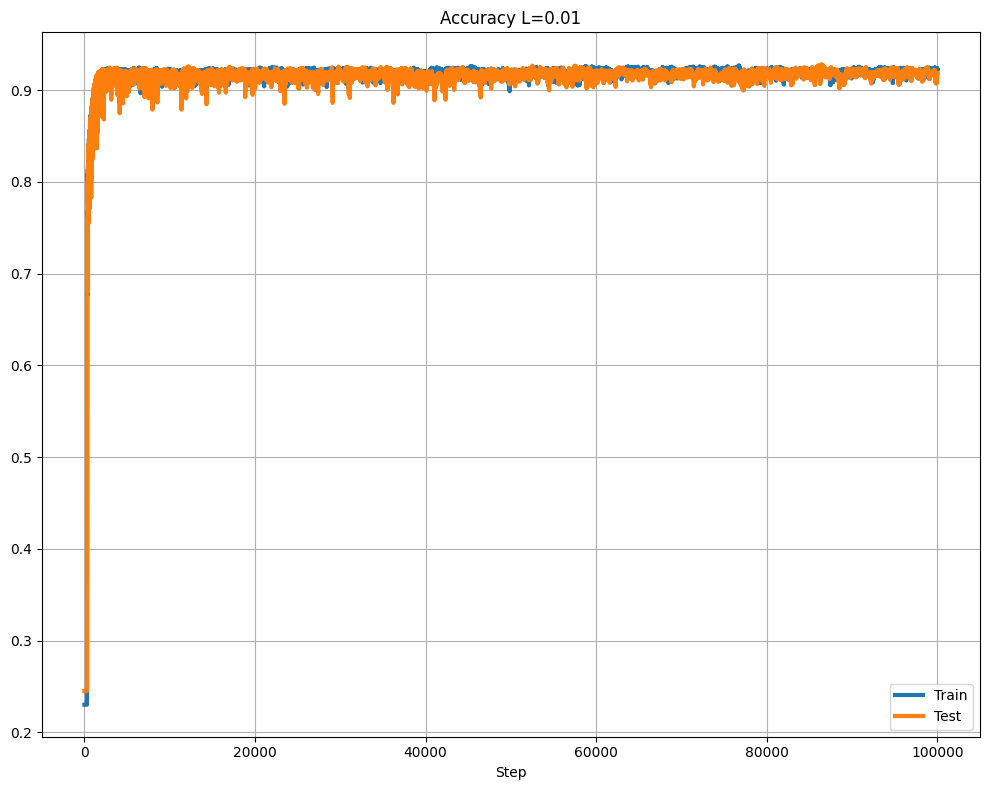

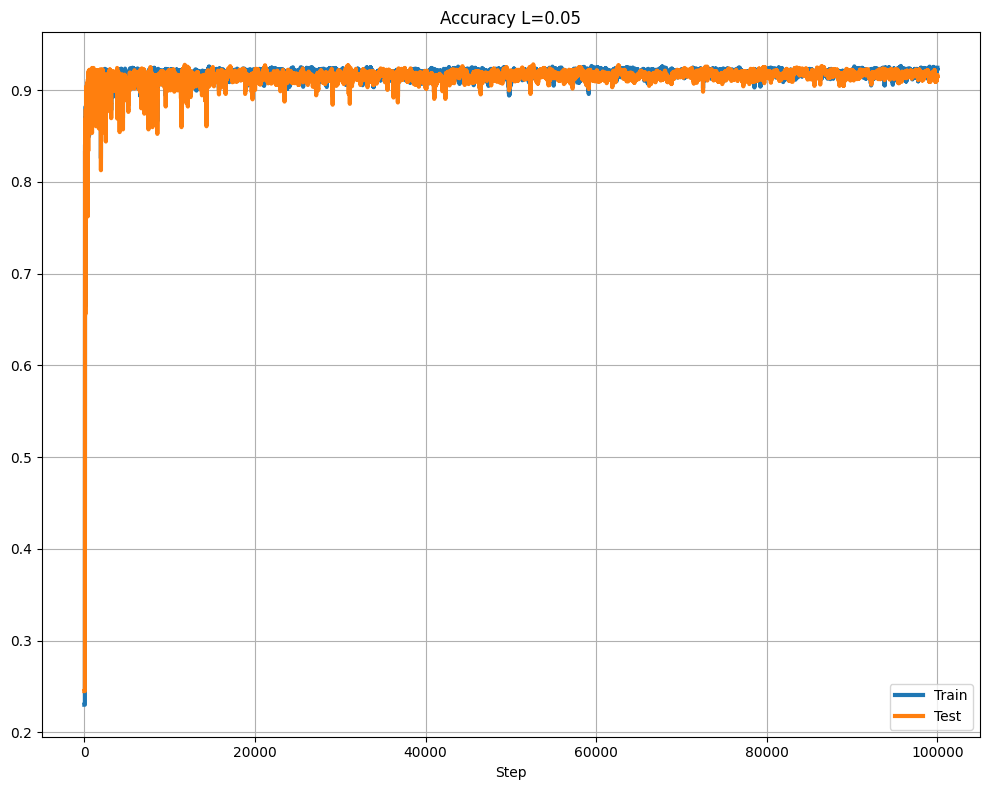

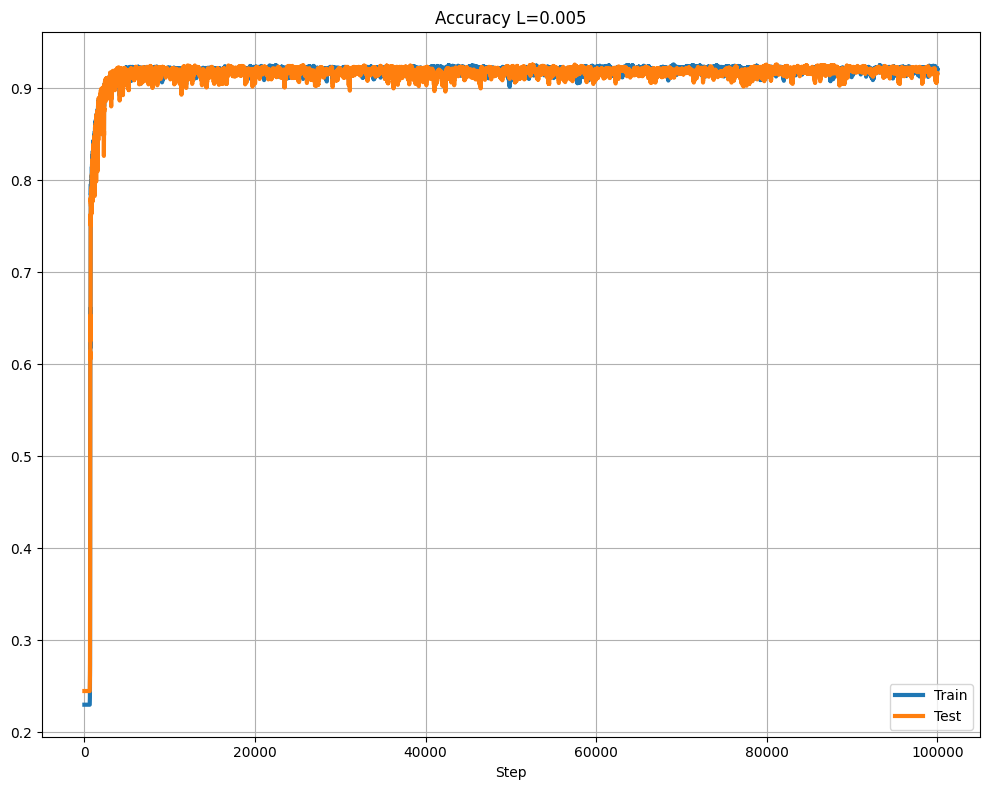

In [7]:
iters_l = [500,1000,3000,10000,50000,100000]
#[300,500,1000,3000,10000,50000,100000,300000] <== Lista que habia originalmente (todas las imagenes están ya contenidas en la carpeta de gráficos)
#A uso práctico, para mejorar la legibilidad de este archivo, voy a deshacer un par de iteradores de la lista de arriba.
L_l = [0.01, 0.05, 0.005]
#Borre de la lista también a 0.001, ya que daba los resultados más bajos de todas las tasas de aprendizaje. Estos gráficos se pueden ver en la carpeta de gráficos

for itrs in iters_l:
    for L in L_l:
        mi_red_neuronal(L=L, iters=itrs)

        #10m 16.5s ejecucion

Viendo los gráficos, obtengo el mejor resultado con 100_000 iteraciones y 0.05 tasa de aprendizaje, con un accuracy de 92,4%. Usaré estos parámetros para la Parte 3. Hay bastantes más párametros que demustran un buen desempeño, con una mínima diferencia. 

### **Punto 4**: Overfitting

Vistos los gráficos, no considero tener overfitting. Las curvas de precisión se mantienen alineadas. 